# 6.2) Supervised Euclidean
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import os
import imageio
import json

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger

from unet import UNet
from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

print(tf.config.get_visible_devices('GPU'))
print(tf.config.get_visible_devices('CPU'))

[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Data
Import training images

In [4]:
path = r'data/SIMPLE/fine_nonrigid'
store_path = 'experiments/6_2_correspondence/fine_nonrigid_250_biased'

width = 224
height = 224

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(224, 224, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Data Preparation
A batch with only one image is used.

In [7]:
fixed = imageio.imread(path + "/fixed.png")
moving = imageio.imread(path + "/moving.png")

fixed = fixed[:,:,0]
moving = moving[:,:,0]

X = np.zeros((width, height, 1))

X[:,:,0] = moving
#X[:,:,1] = fixed

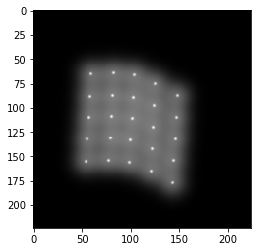

In [8]:
plt.imshow(X[:,:,0], cmap="gray")

In [9]:
X.shape

(224, 224, 1)

In [10]:
moving_json_file = open(path  + '/moving.json')
fixed_json_file = open(path + '/fixed.json')

moving_data = json.load(moving_json_file)
fixed_data = json.load(fixed_json_file)

moving_json_file.close()
fixed_json_file.close()

labels = np.zeros((25,2,2))

for index in range(0,25):
    x = moving_data[str(index)][0]
    y = moving_data[str(index)][1]

    labels[index][0][0] = x
    labels[index][1][0] = y
    
for index in range(0,25):
    x = fixed_data[str(index)][0]
    y = fixed_data[str(index)][1]

    labels[index][0][1] = x
    labels[index][1][1] = y  

# Training Preparation
Prepare the settings for training the model.

In [11]:
X_train = np.array([X])
y_train = np.array([labels])

In [12]:
def eval_displacment(u, x, y):
    u = kb.gather(u, y)
    u = kb.transpose(u)
    u = kb.gather(u, x)
    u = kb.flatten(u)
    indices = [val * 25 + val for val in range(0,25)]
    u = kb.gather(u, indices)
    
    return u

def custom_loss(labels, prediction):
    # BATCH_SIZE = 1
    
    #print(prediction.shape) # batch_sizex112x112x2 (bs, x, y, ux-uy)
    #print(labels.shape) # batch_sizex25x2x2 (bs, coord, x-y, mov-fix)
    
    ux = prediction[0,:,:,0]
    uy = prediction[0,:,:,1]
    
    x_mov = labels[0,:,0,0]
    y_mov = labels[0,:,1,0]
    x_mov_int = kb.cast(x_mov, "int32")
    y_mov_int = kb.cast(y_mov, "int32")
    
    x_fix = labels[0,:,0,1]
    y_fix = labels[0,:,1,1]
    x_fix_int = kb.cast(x_fix, "int32")
    y_fix_int = kb.cast(y_fix, "int32")    
    
    ux_mov = eval_displacment(ux, x_mov_int, y_mov_int)
    uy_mov = eval_displacment(uy, x_mov_int, y_mov_int)
    
    x_squared = kb.square(x_mov + ux_mov - x_fix) # elementwise
    y_squared = kb.square(y_mov + uy_mov - y_fix) 
    
    euclidean_distance = kb.sqrt(x_squared + y_squared)
    mae = kb.mean(x_squared + y_squared)
    
    #mse = kb.mean(x_squared + y_squared)
    #kb.print_tensor(mse)
    
    return mae

In [13]:
logger = CSVLogger(store_path + "/log")

callbacks = [logger]

model.compile(optimizer='adam', loss = custom_loss)
model.fit(X_train, y_train, validation_data=(X_train, y_train), callbacks=callbacks, batch_size=1, epochs=250)

Epoch 1/250
1/1 [==============================] - 1s 670ms/step - loss: 159.0873 - val_loss: 9428.0020
Epoch 2/250
1/1 [==============================] - 0s 151ms/step - loss: 141.7348 - val_loss: 46591.5859
Epoch 3/250
1/1 [==============================] - 0s 151ms/step - loss: 80.6730 - val_loss: 239378.7656
Epoch 4/250
1/1 [==============================] - 0s 149ms/step - loss: 64.9247 - val_loss: 602053.4375
Epoch 5/250
1/1 [==============================] - 0s 146ms/step - loss: 50.8815 - val_loss: 971985.8125
Epoch 6/250
1/1 [==============================] - 0s 148ms/step - loss: 37.3633 - val_loss: 1238488.7500
Epoch 7/250
1/1 [==============================] - 0s 147ms/step - loss: 21.0618 - val_loss: 1609741.0000
Epoch 8/250
1/1 [==============================] - 0s 146ms/step - loss: 9.9817 - val_loss: 1907821.1250
Epoch 9/250
1/1 [==============================] - 0s 153ms/step - loss: 3.6046 - val_loss: 2087713.0000
Epoch 10/250
1/1 [==============================] - 0s

1/1 [==============================] - 0s 149ms/step - loss: 8.8540e-04 - val_loss: 1627.6775
Epoch 80/250
1/1 [==============================] - 0s 146ms/step - loss: 5.0118e-04 - val_loss: 1509.8364
Epoch 81/250
1/1 [==============================] - 0s 154ms/step - loss: 7.9518e-04 - val_loss: 1401.2056
Epoch 82/250
1/1 [==============================] - 0s 151ms/step - loss: 3.5580e-04 - val_loss: 1299.8799
Epoch 83/250
1/1 [==============================] - 0s 148ms/step - loss: 6.2139e-04 - val_loss: 1205.1785
Epoch 84/250
1/1 [==============================] - 0s 146ms/step - loss: 3.5485e-04 - val_loss: 1117.9402
Epoch 85/250
1/1 [==============================] - 0s 148ms/step - loss: 4.5393e-04 - val_loss: 1039.2172
Epoch 86/250
1/1 [==============================] - 0s 145ms/step - loss: 3.1567e-04 - val_loss: 969.8324
Epoch 87/250
1/1 [==============================] - 0s 145ms/step - loss: 3.0677e-04 - val_loss: 907.9956
Epoch 88/250
1/1 [==============================] - 

Epoch 156/250
1/1 [==============================] - 0s 148ms/step - loss: 4.4929e-07 - val_loss: 56.2310
Epoch 157/250
1/1 [==============================] - 0s 148ms/step - loss: 2.2658e-07 - val_loss: 54.7848
Epoch 158/250
1/1 [==============================] - 0s 154ms/step - loss: 2.0825e-07 - val_loss: 53.4041
Epoch 159/250
1/1 [==============================] - 0s 215ms/step - loss: 4.6418e-07 - val_loss: 52.0465
Epoch 160/250
1/1 [==============================] - 0s 169ms/step - loss: 2.6620e-07 - val_loss: 50.7530
Epoch 161/250
1/1 [==============================] - 0s 152ms/step - loss: 9.4580e-08 - val_loss: 49.4971
Epoch 162/250
1/1 [==============================] - 0s 149ms/step - loss: 2.3063e-07 - val_loss: 48.2747
Epoch 163/250
1/1 [==============================] - 0s 148ms/step - loss: 3.0482e-07 - val_loss: 47.1342
Epoch 164/250
1/1 [==============================] - 0s 166ms/step - loss: 1.8440e-07 - val_loss: 46.0215
Epoch 165/250
1/1 [===========================

1/1 [==============================] - 0s 148ms/step - loss: 2.9197e-09 - val_loss: 11.4357
Epoch 234/250
1/1 [==============================] - 0s 145ms/step - loss: 3.0664e-09 - val_loss: 11.2437
Epoch 235/250
1/1 [==============================] - 0s 151ms/step - loss: 4.4750e-09 - val_loss: 11.0520
Epoch 236/250
1/1 [==============================] - 0s 153ms/step - loss: 7.8278e-09 - val_loss: 10.8679
Epoch 237/250
1/1 [==============================] - 0s 151ms/step - loss: 1.5420e-08 - val_loss: 10.6867
Epoch 238/250
1/1 [==============================] - 0s 157ms/step - loss: 3.0359e-08 - val_loss: 10.5130
Epoch 239/250
1/1 [==============================] - 0s 150ms/step - loss: 5.8718e-08 - val_loss: 10.3349
Epoch 240/250
1/1 [==============================] - 0s 145ms/step - loss: 1.1453e-07 - val_loss: 10.1686
Epoch 241/250
1/1 [==============================] - 0s 147ms/step - loss: 2.4127e-07 - val_loss: 9.9940
Epoch 242/250
1/1 [==============================] - 0s 147ms

In [14]:
model.save_weights(store_path + "/weights.hdf5")

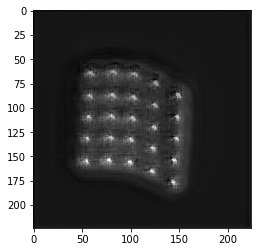

In [15]:
y_pred = model.predict(X_train)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

In [16]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

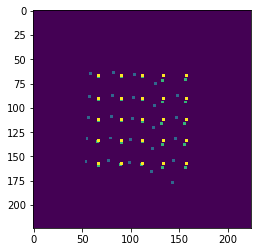

In [17]:
warp = np.zeros((width, height))

for index in range(0,25):
    x = moving_data[str(index)][0]
    y = moving_data[str(index)][1]
    
    plot_cube(warp, x, y, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y][x]
    uy = uy_field[y][x]
    
    x = int(round(x + ux))
    y = int(round(y + uy))
            
    plot_cube(warp, x, y, 2) #green    
    
    x = fixed_data[str(index)][0]
    y = fixed_data[str(index)][1]
    
    plot_cube(warp, x, y, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)